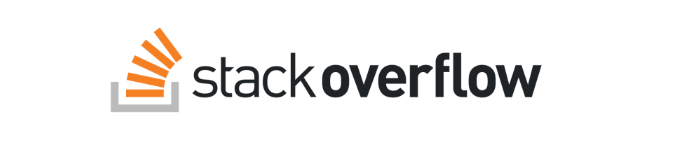

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import defaultdict, Counter
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import string
from sklearn.manifold import TSNE
from wordcloud import WordCloud, STOPWORDS
import gc
import nltk
import pickle
import time
from sklearn import cluster, metrics
from sklearn import manifold, decomposition
import logging
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
# Download the required NLTK data
nltk.download('stopwords')
nltk.download('wordnet')

from pickle import dump

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\perso\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\perso\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
df = pd.read_csv("QueryResults_MLsupervisee.csv")
print(df.shape)

(40682, 7)


In [3]:
df

,Tags_filtered,Tags_filtered_len,Words_filtered,Words_filtered_len,Texte_len,Tags_len,Tags_len_ratio
0,iphone objective-c,2.0,use try iphone,3.0,14,18,1.0
1,java xml,2.0,content xml file xml know type xml use java ap...,33.0,169,8,21.0
2,database,1.0,set database like think would way web service ...,43.0,228,8,28.0
3,java,1.0,change see also java however seem work follow ...,27.0,155,4,39.0
4,ios macos,2.0,load file source macos io question use io maco...,111.0,585,9,65.0
...,...,...,...,...,...,...,...
40677,c# wpf,2.0,wpf view app xml see view net however case mak...,27.0,151,6,25.0
40678,ios objective-c,2.0,json json data url string url return code want...,44.0,245,15,16.0
40679,javascript node.js,2.0,javascript j different path use code something...,8.0,53,18,3.0
40680,java android unit-testing,3.0,android test class fail compile error write an...,36.0,202,25,8.0


In [4]:
# Replace spaces with commas in 'Tags' and 'Text' columns
df['Tags'] = df['Tags_filtered'].str.replace(' ', ', ')
df['Text'] = df['Words_filtered'].str.replace(' ', ', ')

In [5]:
def add_brackets(s):
    return '[' + s + ']'

In [6]:
df['Text'] = df['Text'].apply(add_brackets)
#df['Tags'] = df['Tags'].apply(add_brackets)

In [7]:
df

,Tags_filtered,Tags_filtered_len,Words_filtered,Words_filtered_len,Texte_len,Tags_len,Tags_len_ratio,Tags,Text
0,iphone objective-c,2.0,use try iphone,3.0,14,18,1.0,"iphone, objective-c","[use, try, iphone]"
1,java xml,2.0,content xml file xml know type xml use java ap...,33.0,169,8,21.0,"java, xml","[content, xml, file, xml, know, type, xml, use..."
2,database,1.0,set database like think would way web service ...,43.0,228,8,28.0,database,"[set, database, like, think, would, way, web, ..."
3,java,1.0,change see also java however seem work follow ...,27.0,155,4,39.0,java,"[change, see, also, java, however, seem, work,..."
4,ios macos,2.0,load file source macos io question use io maco...,111.0,585,9,65.0,"ios, macos","[load, file, source, macos, io, question, use,..."
...,...,...,...,...,...,...,...,...,...
40677,c# wpf,2.0,wpf view app xml see view net however case mak...,27.0,151,6,25.0,"c#, wpf","[wpf, view, app, xml, see, view, net, however,..."
40678,ios objective-c,2.0,json json data url string url return code want...,44.0,245,15,16.0,"ios, objective-c","[json, json, data, url, string, url, return, c..."
40679,javascript node.js,2.0,javascript j different path use code something...,8.0,53,18,3.0,"javascript, node.js","[javascript, j, different, path, use, code, so..."
40680,java android unit-testing,3.0,android test class fail compile error write an...,36.0,202,25,8.0,"java, android, unit-testing","[android, test, class, fail, compile, error, w..."


# Models non supervisés

In [ ]:
import gensim
from gensim.models import TfidfModel
import gensim.corpora as corpora
from gensim import models
from gensim.utils import simple_preprocess
from gensim.models.ldamulticore import LdaMulticore
from gensim.models import CoherenceModel
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import logging
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

##  Latent Dirichlet Allocation (LDA)
C’est une méthode non-supervisée générative qui se base sur les hypothèses suivantes :

* Chaque document du corpus est un ensemble de mots sans ordre (bag-of-words) ;

* Chaque document aborde un certain nombre de thèmes dans différentes proportions qui lui sont propres p(θm)

* Chaque mot possède une distribution associée à chaque thème p(ϕk). On peut ainsi représenter chaque thème par une probabilité sur chaque mot.

* zn représente le thème du mot wn

On peut déterminer quels sont les thèmes, les distributions de chaque mot sur les thèmes, la fréquence d’apparition de chaque thème sur le corpus.

Une représentation formelle sous forme de modèle probabiliste graphique est la suivante :

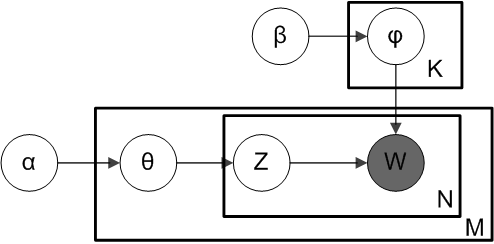

In [ ]:
# Créer une liste de listes de mots à partir de la colonne 'Words_filtered'
documents = df['Words_filtered'].apply(lambda x: x.split()).tolist()

# Créer le dictionnaire de mots avec gensim
gensim_dictionary = corpora.Dictionary(documents)

# Créer le corpus de documents sous forme de sac de mots avec le dictionnaire
corpus = [gensim_dictionary.doc2bow(doc) for doc in documents]

In [ ]:
#printing the corpus we created above.
print(corpus[:3]) 

In [ ]:
#we can print the words with their frequencies.

[[(gensim_dictionary[id], freq) for id, freq in cp] for cp in corpus[:4]] 

In [ ]:
# stock result of coherence and perplexity score
results = []

# loop for find the best topic :
for n_topics in [4, 5, 6, 7, 8, 9, 10, 11, 12]:

    # creating the LDA model
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                id2word=gensim_dictionary,
                                                num_topics=n_topics,
                                                random_state=0,
                                                update_every=1,
                                                chunksize=100,
                                                passes=10,
                                                alpha='auto'
                                                )

    # creation score :
    Perplexity_Score = lda_model.log_perplexity(corpus)
    Coherence_Score = CoherenceModel(model=lda_model,
                                     texts=documents,
                                     dictionary=gensim_dictionary,
                                     coherence='c_v'
                                     ).get_coherence()

    # Visualize the results :
    print('-'*40)
    print(f" For {n_topics} topics :")
    print('-'*40)
    print('')

    # Compute Perplexity
    # a measure of how good the model is. lower the better.
    print(f"Perplexity Score : {Perplexity_Score}")
    print('')

    # Compute Coherence Score
    print(f"Coherence Score : {Coherence_Score}")

    results.append([n_topics, Perplexity_Score, Coherence_Score])

In [ ]:
fig,ax= plt.subplots(figsize=(15, 15))

# 1st line :
ax.plot([line[0] for line in results],
        [line[1] for line in results],
        color = "b",
        label = 'perplexity_score')
ax.set_ylabel('perplexity_score')
ax.set_xlabel('Number of Topics')


# to have same size for score :
ax2 = ax.twinx()

# 2nd line :
ax2.plot([line[0] for line in results],
        [line[2] for line in results],
        color = "g",
        label = 'coherence_score')
ax2.set_ylabel('coherence_score')

fig.legend()

### Optimisation LDA

In [ ]:
# number of topics
num_topics = 6

# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=gensim_dictionary,
                                       num_topics=num_topics)

# Define the number of top words to print for each topic
no_top_words = 20

# Print the top words in the 6 topics
for topic_idx in range(num_topics):
    print("Topic {}:".format(topic_idx))
    top_words = lda_model.get_topic_terms(topic_idx, topn=no_top_words)
    top_word_strings = [gensim_dictionary[i] for i, _ in top_words]
    print(" ".join(top_word_strings))
    print()

doc_lda = lda_model[corpus]

### Analyzing LDA model results

Maintenant que nous disposons d'un modèle entraîné, visualisons les sujets pour en faciliter l'interprétation. Pour ce faire, nous utiliserons un paquetage de visualisation populaire, pyLDAvis, qui est conçu pour aider de manière interactive à :

Mieux comprendre et interpréter les sujets individuels, et
Mieux comprendre les relations entre les sujets.
Pour (1), vous pouvez sélectionner manuellement chaque sujet pour visualiser les termes les plus fréquents et/ou les plus "pertinents", en utilisant différentes valeurs du paramètre λ. Cela peut s'avérer utile lorsque vous essayez d'attribuer un nom ou une "signification" interprétable par l'homme à chaque thème.

Pour (2), l'exploration du graphe de la distance inter-sujets peut vous aider à comprendre comment les sujets sont liés les uns aux autres, y compris une structure potentielle de plus haut niveau entre les groupes de sujets.

In [ ]:
import pyLDAvis.gensim_models
import gensim

data = pyLDAvis.gensim_models.prepare(lda_model, corpus, gensim_dictionary)

# Visualisation interactive
pyLDAvis.show(data)

## NMF

In [ ]:
from sklearn.decomposition import NMF

In [ ]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic {}:".format(topic_idx))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))
        print()

In [ ]:
# Define the number of features to use
n_features = 1000

# Define the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, 
                                    min_df=2, 
                                    max_features=n_features, 
                                    stop_words='english')

# Fit and transform the TF-IDF matrix
tfidf = tfidf_vectorizer.fit_transform(Words)

# Get the feature names from the TF-IDF vectorizer
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

# Define the number of topics for NMF
n_components = 5

# Run NMF
nmf = NMF(n_components=n_components, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd')
nmf.fit(tfidf)

# Define the number of top words to display for each topic
n_top_words = 20

# Display the top words for each topic
display_topics(nmf, tfidf_feature_names, n_top_words)

In [ ]:
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(1, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx +1}',
                     fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

In [ ]:
# Visualisation
plot_top_words(nmf, tfidf_feature_names, n_top_words,
               'Topics in NMF model (Frobenius norm)')